<a href="https://colab.research.google.com/github/sapperka/AZSII/blob/main/%D0%90%D0%97%D0%A1%D0%98%D0%98_%D0%91%D0%91%D0%9C%D0%9E_02_23_%D0%A0%D1%8B%D0%B1%D0%B0%D0%BA%D0%BE%D0%B2_%D0%9F%D0%A04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# АЗСИИ

## Практика 4: Атака DeepFool на модели ИИ

Группа: ББМО-02-23

Студент: Рыбаков Владислав Андреевич

## Цель задания:
Изучить атаку DeepFool, которая предназначена для минимальных изменений в изображениях с
целью изменения их классификации. Научиться использовать эту атаку и исследовать влияние
противоречивых примеров на обученные модели.

## Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки DeepFool.
3. Реализовать атаку DeepFool с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.

## Шаги выполнения:

### Шаг 1: Загрузка обученной модели и данных MNIST
Мы начнем с загрузки обученной модели и данных MNIST, которые будем использовать для
проведения атаки.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0876
Test accuracy on clean images: 0.9768999814987183


### Шаг 2: Теория атаки DeepFool
Атака DeepFool — это метод, который был разработан для минимального изменения изображений с
целью заставить классификационную модель ошибиться. В отличие от других атак, таких как FGSM,
DeepFool находит минимальные изменения в пространстве признаков, которые достаточны для
изменения предсказания модели. Это делает DeepFool более эффективной в создании
противоречивых примеров с минимальным изменением входных данных.

### Шаг 3: Реализация атаки DeepFool с использованием Foolbox
Для выполнения атаки DeepFool мы будем использовать библиотеку Foolbox, которая поддерживает
различные атаки на модели ИИ, включая DeepFool.
Установка Foolbox:

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.2 MB/s eta 0:00:00


Реализация атаки DeepFool:

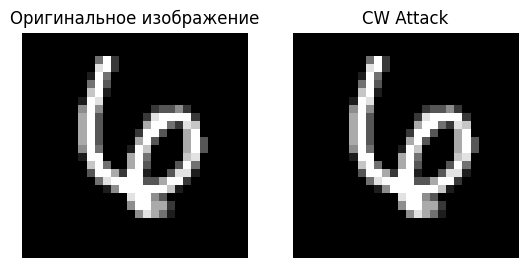

In [8]:
import foolbox as fb
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[22], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Создание атаки DeepFool
attack = fb.attacks.L2DeepFoolAttack(steps=100)

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("CW Attack")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

### Шаг 4: Оценка модели на противоречивых примерах
Теперь мы проверим, насколько сильно атака DeepFool влияет на точность модели. Мы создадим
набор противоречивых примеров и оценим производительность модели на этих данных.

In [10]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 58.2310
Accuracy on adversarial examples (DeepFool): 0.0


### Шаг 5: Сравнение результатов
#### Вывод:
Точность модели на атакованных примерах близка к 0%, что свидетельствует о её высокой уязвимости к небольшим, но целенаправленным изменениям в изображениях, способным обмануть модель. Например, атака DeepFool с минимальными изменениями существенно снижает способность модели корректно классифицировать данные.

Это падение точности указывает на недостаточную устойчивость модели к внешним воздействиям, что критично в реальных приложениях, где изображения могут быть искажены или намеренно изменены. В системах безопасности или автономного транспорта такие уязвимости могут использоваться для искажения результатов распознавания объектов.

Подобные результаты подчёркивают необходимость разработки моделей, устойчивых к атакам, особенно в условиях, предполагающих потенциальную враждебность среды.